## Import

In [10]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import medmnist
from medmnist import PneumoniaMNIST
import seaborn as sns
from medmnist import INFO, Evaluator

## Visualisation
`dataset`: gives description of dataset\
`dataset[n][0]` the image of patient n\
`dataset[n][1]` binary classification class: `[0]` = normal, `[1]` = pneumonia

In this section, we import the 'test' section of the dataset for visualisation. **Note:** None of these variables used after this block.

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\veedu\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


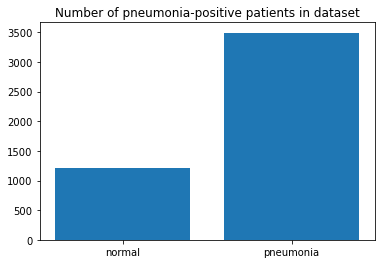

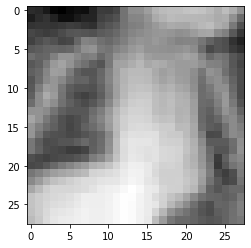

In [11]:
dataset = PneumoniaMNIST(split='train',download=False)
print(dataset)
normal=0
pneumonia=0
for image in dataset: 
    if image[1] == [0]: 
        normal+=1
    elif image[1] == [1]: 
        pneumonia+=1

plt.bar(('normal','pneumonia'),(normal,pneumonia))
plt.title('Number of pneumonia-positive patients in dataset')
plt.show()

plt.imshow(dataset[np.random.randint(len(dataset))][0],cmap='gray') #show random patient
baseline=pneumonia/(pneumonia+normal)

## Dataset Variables

`INFO` method of `medmnist` provides all information about the dataset, type=dictionary. We extract some of the information from this for later use in the training process. 

Hyperparameters -- crucial to control for good results:
1. `NUM_EPOCHS`: number of times the neural network is trained on the entire dataset.
2. `BATCH_SIZE`: number of images before parameters of the NN are updates.
3. `lr`: learning rate, controls how much the network's parameters are adjusted based on the errors during training.

In [47]:
data_flag = 'pneumoniamnist'
download = False

num_epochs = 100#no. of times the NN is trained on the entire dataset
batch_size = 32 #no. of images before parameters are updated
lr = 1e-5

info = INFO[data_flag]
task = info['task'] #binary classification or multi-classification?
n_channels = info['n_channels'] #colour channels
n_classes = len(info['label']) #number of classes

DataClass = getattr(medmnist, info['python_class'])

## Preprocessing
1. Define data transformer to transform PIL images into a tensor format, and apply a normalisation for better performance. 
2. Use the `DataClass` method defined above to create training and test dataset.
3. `DataLoader`: Split data into batches and shuffle to avoid overfitting.

In [14]:
# Define Data Transform function
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


# Import Data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
validation_dataset = DataClass(split='val',transform=data_transform, download=download)

# Data loaders
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

## CNN Structure

First, define layers of CNN. Sequential Structure. 

1. `nn.Conv2d:` Applies 2D convolutions to extract features from images.
2. `nn.BatchNorm2d:` Normalizes input to stabilize training.
3. `nn.ReLU:` Type of activation function: introduces non-linearity for better learning.
4. `nn.MaxPool2d:` Downsamples feature maps to reduce parameters and computational cost.

Class `Net` inherits all functions from PyTorch `nn.module`. 

Next, define the optimiser and loss function.
1. **Loss Function**: A loss function measures the difference between the model's predictions and the actual labels. Common choice is Cross-Entropy Loss -- penalizes the model for making incorrect predictions, considering the probability distribution of the predicted classes. 
2. **Optimiser:**  updates the model's internal parameters (weights and biases) based on the calculated loss.

In [58]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Quality Evaluation

Now, using the trained network, evaluate if the network predicts the correct outputs for the test dataset.
- `model(inputs)` returns an array, where each element in the array is a number corresponding to the likelihood of the image being in this class.
- `softmax` normalises these raw numbers into probabilities. 
- Two arrays are created, one to store the actual label `y_true` and the other to store the prediction `y_score`. 
- Create an evaluator function from the `mednist` library and feed `y_score`. 
- Returns two metrics: accuracy (acc) and area under curve (auc). 

auc: consists of *True Positive Rate* : Proportion of actual positive cases correctly identified as positive by the model (also known as Recall) and *False Positive Rate*: Proportion of actual negative cases incorrectly identified as positive by the model (also known as Type I error).

In [24]:
def evaluator(model,loader,label,acc_array,epoch=1):
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Process target and outputs (on GPU)
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)  # convert to probability
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)  # targets
            y_score = torch.cat((y_score, outputs), 0)  # predicted output + probability

        y_true = y_true.cpu().numpy()  # Move data back to CPU for evaluation
        y_score = y_score.cpu().detach().numpy()
                
        evaluator = Evaluator(data_flag, label)
        auc, acc = evaluator.evaluate(y_score)
        acc_array[epoch] = acc
    return y_true, y_score, acc_array

## Training
*How does the training process work?*
1. Model takes a batch of images and their corresponding labels.
2. It predicts class probabilities for each image.
3. The loss function calculates the difference between these predictions and the true labels.
4. The gradients of the loss function with respect to each model parameter are computed (backpropagation).
5. The chosen optimizer uses these gradients to update the model's parameters in a direction that reduces the loss.
6. This process repeats for each batch of data over multiple epochs (complete passes through the entire dataset).

*Code*: 
For each epoch: 
1. Set model to traning mode
2. Refer back to `train_loader` variable: this is the training dataset split into a number of each batches. Code loops through each batch. `inputs` = input images, `targets` = image label
3. For each batch, set optimiser to zero. Feed inputs through the network, and evaluate the loss function. Perform back propagation then update parameters.
4. Evaluate current performance on validation and testing set.

In [59]:
# Check for available GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



# Move model and tensors to GPU
model = Net(n_channels,n_classes).to(device)  # Move model to GPU
criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

val_acc_array = np.zeros(num_epochs)
test_acc_array = np.zeros(num_epochs)
# Move data to GPU inside the loops
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

    model.eval()
    _, _, val_acc_array = evaluator(model,val_loader,'val',val_acc_array,epoch)
    y_true, y_score, test_acc_array = evaluator(model,test_loader,'test',test_acc_array,epoch)





Accuracy Plot

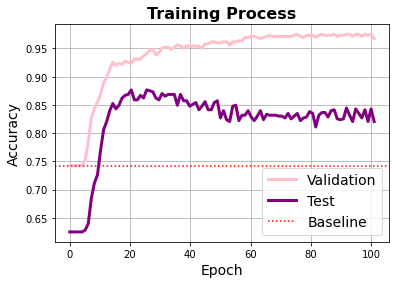

In [61]:
n=np.linspace(0,num_epochs+1,num_epochs)
plt.plot(n,val_acc_array,color='pink',lw=3,label='Validation')
plt.plot(n,test_acc_array,color='purple',lw=3,label='Test')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.axhline(baseline,color='red',ls=':',label='Baseline')
plt.legend(loc='lower right',fontsize=14)
plt.title('Training Process',fontsize=16,fontweight='bold')
plt.grid()
plt.savefig('training.jpeg')
plt.show()




Confusion Matrix

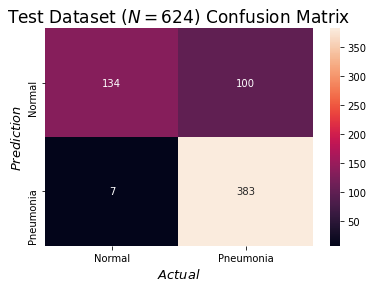

              precision    recall  f1-score   support

         0.0       0.95      0.57      0.71       234
         1.0       0.79      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624



In [21]:
y_pred_classes = np.argmax(y_score, axis=1)  # Get predicted class indices
cm = confusion_matrix(y_true, y_pred_classes)
class_names = ['Normal', 'Pneumonia']
samples = len(test_dataset)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('$\it{Prediction}$',fontsize=13)
plt.xlabel('$\it{Actual}$',fontsize=13)
plt.title(f'Test Dataset ($N={samples}$) Confusion Matrix',fontsize=17)
plt.show()

 
print(classification_report(y_true, y_pred_classes))